In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import matplotlib.colors as cls
import gdal
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from tqdm import tqdm

## Import and explore data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#import dem data first
dataset_dem = gdal.Open("/content/drive/MyDrive/Minerva Stuff/CS166/ASTGTM_NC.003_ASTER_GDEM_DEM_doy2000061_aid0001.tif")
dataset_dem.RasterCount, dataset_dem.RasterXSize, dataset_dem.RasterYSize #check data size

(1, 12236, 9704)

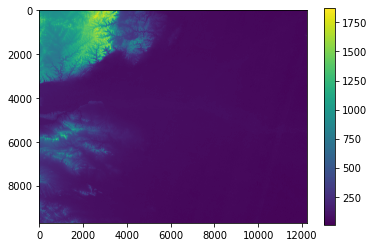

In [20]:
#visualize the dem
band_dem = dataset_dem.GetRasterBand(1)
arr_dem = band_dem.ReadAsArray()
plt.imshow(arr_dem)
plt.colorbar()

We do not see the river we are interested in, but that is just because of higher elevation differences in other places. Lets visualize other datasets.

In [6]:
dataset_wb = gdal.Open("/content/drive/MyDrive/Minerva Stuff/CS166/ASTWBD_NC.001_ASTWBD_dem_doy2000061_aid0001.tif")
dataset_wb.RasterCount, dataset_wb.RasterXSize, dataset_wb.RasterYSize

(1, 12236, 9704)

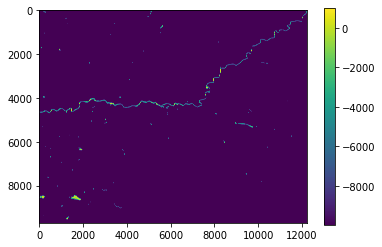

In [7]:
band_wb = dataset_wb.GetRasterBand(1)
arr_wb = band_wb.ReadAsArray()
plt.imshow(arr_wb)
plt.colorbar()

We can now see the thin river flowing through our study area!! next, we visulaize the masked data for water bodies.

In [8]:
dataset_wb2 = gdal.Open("/content/drive/MyDrive/Minerva Stuff/CS166/ASTWBD_ATTNC.001_ASTWBD_att_doy2000061_aid0001.tif")
dataset_wb2.RasterCount, dataset_wb2.RasterXSize, dataset_wb2.RasterYSize

(1, 12236, 9704)

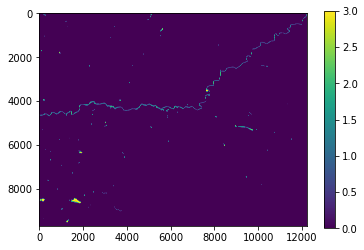

In [9]:
band_wb2 = dataset_wb2.GetRasterBand(1)
arr_wb2 = band_wb2.ReadAsArray()
plt.imshow(arr_wb2)
plt.colorbar()

We have one last dataset which is the land cover type. This data set tells us the type of land cover in our selected region. This will help us in selecting for infiltration and roughness values. One of the values we choose is the Manning coefficient. As we will see in our dataset visualization, most of the land cover is very similar. Hence, we can get away with just having 2 different manning coefficient values: a value for water bodies and another value for all the rest of the land, which will be vegetation cover. Similarly, infiltration coefficient will be 0 for water bodies and 0.001 for land. This means that the water bodies are already waterlogged but we could have an infiltration of 1mm for every 1m of water column on land.

In [10]:
dataset_lc = gdal.Open("/content/drive/MyDrive/Minerva Stuff/CS166/MCD12Q1.006_LC_Type1_doy2020001_aid0001.tif")
dataset_lc.RasterCount, dataset_lc.RasterXSize, dataset_lc.RasterYSize

(1, 817, 648)

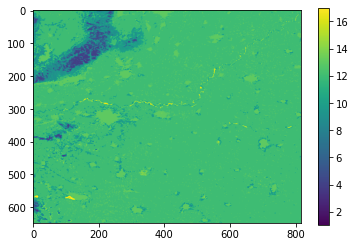

In [11]:
band_lc = dataset_lc.GetRasterBand(1)
arr_lc = band_lc.ReadAsArray()
plt.imshow(arr_lc)
plt.colorbar()

## Exploring Datasets Further

The next few code blocks verify that the DEM dataset already includes the elevation of water bodies and we do not need to add it to the DEM data.

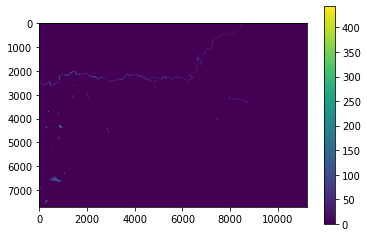

In [12]:
arr_wb_new = np.where(arr_wb == -9999, 0, arr_wb)
plt.imshow(arr_wb_new[2000:, 1000:])
plt.colorbar()

(-50.0, 1050.0, -50.0, 1050.0)

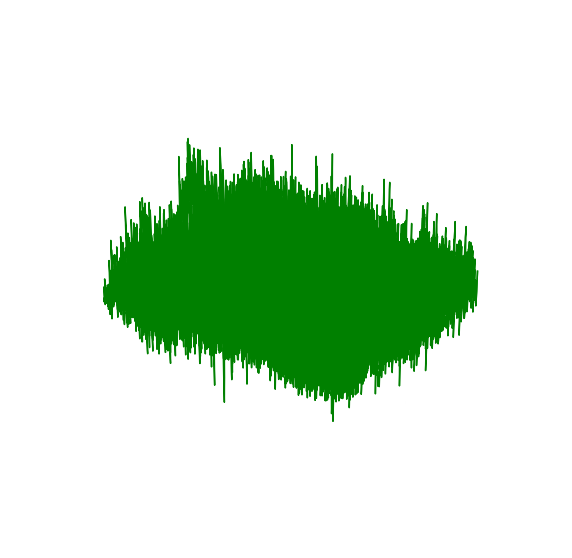

In [21]:
fig = plt.figure(figsize=(10, 10))
 
# Generating a 3D sine wave
ax = plt.axes(projection='3d')

# assigning coordinates
y = np.linspace(0, 1000, 1000)
x = np.linspace(0, 1000, 1000)
X, Y = np.meshgrid(x, y)
Z = arr_dem[5500:6500, 5000:6000]
 
# creating the visualization
ax.plot_wireframe(X, Y, Z, color ='green')

# turn off/on axis
plt.axis('off')

(-50.0, 1050.0, -50.0, 1050.0)

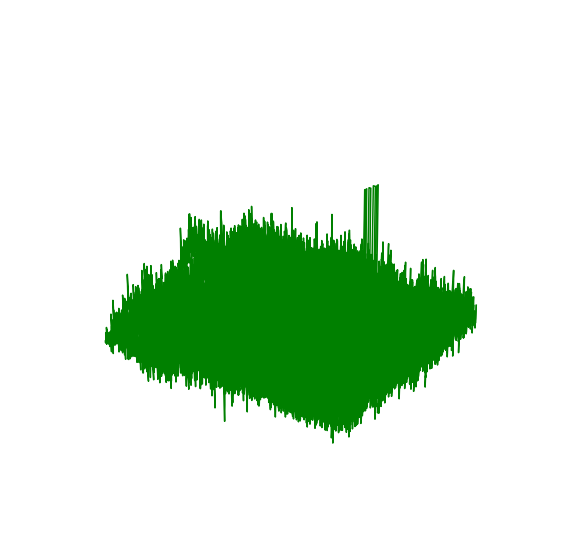

In [22]:
fig = plt.figure(figsize=(10, 10))
 
# Generating a 3D sine wave
ax = plt.axes(projection='3d')

# assigning coordinates
y = np.linspace(0, 1000, 1000)
x = np.linspace(0, 1000, 1000)
X, Y = np.meshgrid(x, y)
Z_1 = (arr_dem+arr_wb_new)[5500:6500, 5000:6000]
 
# creating the visualization
ax.plot_wireframe(X, Y, Z_1, color ='green')

plt.axis('off')

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


(-200.0, 4200.0, -100.0, 2100.0)

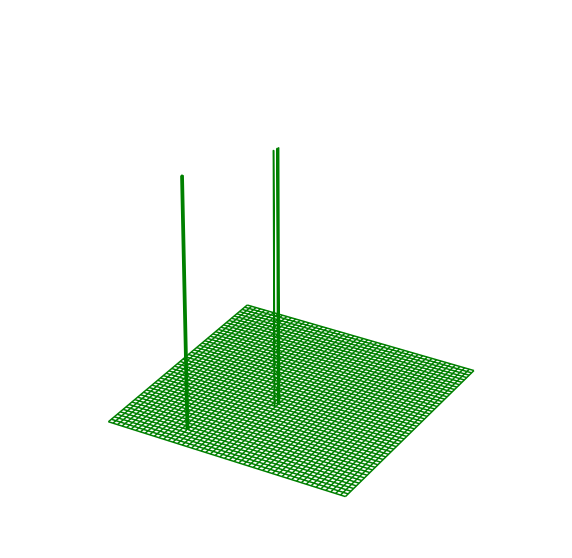

In [23]:
fig = plt.figure(figsize=(10, 10))
 
# Generating a 3D sine wave
ax = plt.axes(projection='3d')

# assigning coordinates
y = np.linspace(0, 2000, 2000)
x = np.linspace(0, 4000, 4000)
X, Y = np.meshgrid(x, y)
Z_2 = arr_wb_new[5000:7000, 4000:8000]
 
# creating the visualization
ax.plot_wireframe(X, Y, Z_2, color ='green')

plt.axis('off')

## Simulation

This is the implementation fo the CA simulation

In [30]:
class Water_Flow_CA:
    """
    Simulate the flow of water on a geographical surface
    Parameters:
    ------------
    dem : array
        A digital elevation model of the region that needs to be simulated
    wbd_mask : array
        A 0, 1, 2, 3 mask of water bodies
    prob_slow : float
        Probability of randomly slowing down velocity of water runoff by 10%
        Default = 0.05
    width : float
        Width of a cell in meters. Default = 30m
    dt : float
        Timestep in seconds, default = 1s
    """
    RIVER_LEVEL = 10.0 #meters
    #manning coefficients for different landtypes
    MANNING_WATER = 0.03
    MANNING_VEGETATION = 0.1
    
    def __init__(self, dem, wbd_mask, prob_slow = 0.05, width = 30, dt = 1):
        """
        Initialize the CA simulation
        """
        self.dem = dem
        self.wbd_mask = wbd_mask
        self.prob_slow = prob_slow
        self.dt = dt
        self.width = width
        self.time_step = 0
        self.pre_processing()
    
    def pre_processing(self):
        """
        Pre-process input data to create required layers
        """
        # initialize water column level: 10 meters of water column for river, 0 everywhere else
        self.water_col = np.where(self.wbd_mask == 2, self.RIVER_LEVEL, 0)
        self.initial_water_col = self.water_col[:, :]

        # initialize waterlogged boolean: only water bodies are waterlogged
        self.waterlogg = np.where(self.wbd_mask == 0, False, True)
        self.underwater = np.where(self.wbd_mask == 0, 0, 1) #store the amount of underground water

        #infiltration coefficient: Only land will have infiltration
        self.infiltration = np.where(self.wbd_mask == 0, 0.001, 0)
        
        #create an array of manning coefficients
        self.manning = np.where(self.wbd_mask == 0, self.MANNING_VEGETATION, self.MANNING_WATER)
        
        #water flow direction
        self.flow_dir = np.zeros(self.dem.shape)    #create an empty array
        for i in range(1, self.dem.shape[0]-1):
            for j in range(1, self.dem.shape[1]-1):
                dir_list = [1, 2, 4, 8, 0, 16, 32, 64, 128] #list of fill values for directions
                neighbors = self.dem[i-1:i+2, j-1: j+2].flatten()
            
                #find minimum elevation among neighbors
                min_elevation = np.min(neighbors)
                min_index = np.where(neighbors == min_elevation)[0]
                #if more than 1 minimum elevation, then choose 1 randomly
                min_index = int(np.random.choice(min_index))
                #add the direction into a new array
                self.flow_dir[i, j] = dir_list[min_index]
        
        #slope array 
        self.slope = np.zeros(self.dem.shape)    #create an empty array
        for i in range(1, self.dem.shape[0]-1):
            for j in range(1, self.dem.shape[1]-1):
                #calculate slope using formula
                f_x = (np.sum(self.dem[i-1:i+2, j+1]) - np.sum(self.dem[i-1:i+2, j-1]))/6*self.width
                f_y = (np.sum(self.dem[i+1, j-1:j+2]) - np.sum(self.dem[i-1, j-1:j+2]))/6*self.width
                self.slope[i, j] = np.sqrt((f_x**2) + (f_y**2))
    
    def update(self):
        """
        Move the simulation forward by dt second(s)
        """

        #calculate velocity of fluid in each cell
        self.vel = (np.cbrt(np.square(self.water_col))*np.sqrt(self.slope))/self.manning

        #random slowing down of water at some cells with some probability
        #we do not speed it up because speeding up the water could cause errors 
        # with amount of water transferred
        self.vel = np.where(np.random.uniform(0, 1, self.vel.shape) < self.prob_slow, self.vel*0.9, self.vel)

        #loop through all cells to update
        temp_wll = np.zeros(self.dem.shape)  #temporary array for saving water influx
        temp_dl = np.zeros(self.dem.shape)   #temporary array for saving drain level
        for i in range(1, self.dem.shape[0]-1):
            for j in range(1, self.dem.shape[1]-1):
                water_influx = 0
                dir_list = [128, 64, 32, 16, 0, 8, 4, 2, 1] #list of fill values for directions
                count = 0
                #check neighbors for higher cells
                for x in range(i-1, i+2):
                    for y in range(j-1, j+2):
                        #transfer water from neighbours to central cell
                        if self.flow_dir[x, y] == dir_list[count]:
                            #volume of water
                            water_influx += self.water_col[x, y]*self.width*self.vel[x, y]*self.dt
                            count+= 1
                #save it in temp_wll - height of influx water column
                temp_wll[i, j] = water_influx/(self.width**2)
                
                #check if central cell has water
                if self.water_col[i, j] > 0:
                    #infiltration if not waterlogged
                    if not self.waterlogg[i, j]:
                        self.water_col[i, j] *= (1-self.infiltration[i, j])
                        self.underwater[i, j] += self.water_col[i, j]*(1-self.infiltration[i, j])
                        if self.underwater[i, j] >= 0.2:
                            self.waterlogg[i, j] = True
                    
                    #outflow of water
                    if self.flow_dir != 0:
                        drain = self.water_col[i, j]*self.width*self.vel[i, j]*self.dt
                        temp_dl[i, j] = drain/(self.width**2)
        
        #update the water column level
        self.water_col += (temp_wll - temp_dl)

        #adjust boundary conditions again: set them to their initial value
        self.water_col[0, :] = self.initial_water_col[0, :]
        self.water_col[-1, :] = self.initial_water_col[-1, :]
        self.water_col[:, 0] = self.initial_water_col[:, 0]
        self.water_col[:, -1] = self.initial_water_col[:, -1]

        #update timestep
        self.time_step += 1
    
    def water_cover(self):
        """
        return the relative water cover for current state
        """
        water_bool = np.where(self.water_col > 0, True, False)
        water_area = np.sum(water_bool)
        relative_area = water_area/self.dem.size
        return relative_area
    
    def initialize(self):
        '''
        This will be called by the animator. It basically just creates figure
        for the figure function to use.
        '''
        # Create a new figure for use in the draw() method below
        self.figure, self.axes = plt.subplots()

    def draw(self):
        '''
        Draw the current state of the cellular automaton.
        '''
        plot = self.axes.imshow(self.water_col)
        self.axes.set_title(f'State at t = {self.time_step} seconds')
        return plot

In [31]:
#function to make animation - taken from session 6
#check if in google colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

def make_animation(sim, total_frames, steps_per_frame=1, interval=100):

    def update(frame_number):
        for _ in range(steps_per_frame):
            sim.update()
        progress_bar.update(1)
        return [sim.draw()]

    sim.initialize()
    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], 
        frames=total_frames, interval=interval)
    if IN_COLAB:
        output = HTML(animation.to_html5_video())
        return output
    return animation



  0%|          | 0/3600 [00:00<?, ?it/s]

IndexError: ignored

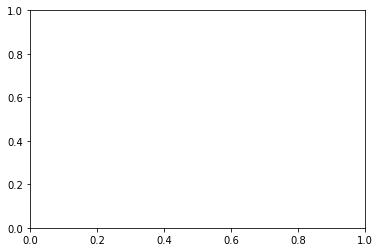

In [32]:
#we will shorten the data set for ease of processing
arr_dem = arr_dem[5000:7000, 4000:6000]
arr_wb2 = arr_wb2[5000:7000, 4000:6000]
yellow_river_sim = Water_Flow_CA(arr_dem, arr_wb2)
make_animation(yellow_river_sim, 3600)